## Setup


In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path

## Default Style Settings
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200
#%matplotlib inline

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset: Wine

In [ ]:
# Load dataset
data_folder = Path("/content/drive/MyDrive/NaturalLanguageUnderstanding/")
wine_reviews = data_folder / 'winemag-data-130k-v2.csv'

In [ ]:
# Inspect the data frame
df = pd.read_csv(wine_reviews, usecols=['description', 'points'], nrows=30000)
df.dropna(how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  30000 non-null  object
 1   points       30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


# Tokenization

In [ ]:
import spacy
from spacy.lang.en import English

# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]  

In [ ]:
# Apply tokenization to descriptions
df['tokens'] = df['description'].apply(tokenize)
df.head()

,description,points,tokens
0,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,"[aromas, include, tropical, fruit, ,, broom, ,, brimstone, and, dried, herb, ., the, palate, is, n't, overly, expressive, ,, offering, unripened, apple, ,, citrus, and, dried, sage, alongside, bri..."
1,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will...",87,"[this, is, ripe, and, fruity, ,, a, wine, that, is, smooth, while, still, structured, ., firm, tannins, are, filled, out, with, juicy, red, berry, fruits, and, freshened, with, acidity, ., it, 's,..."
2,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,"[tart, and, snappy, ,, the, flavors, of, lime, flesh, and, rind, dominate, ., some, green, pineapple, pokes, through, ,, with, crisp, acidity, underscoring, the, flavors, ., the, wine, was, all, s..."
3,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,"[pineapple, rind, ,, lemon, pith, and, orange, blossom, start, off, the, aromas, ., the, palate, is, a, bit, more, opulent, ,, with, notes, of, honey, -, drizzled, guava, and, mango, giving, way, ..."
4,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country...",87,"[much, like, the, regular, bottling, from, 2012, ,, this, comes, across, as, rather, rough, and, tannic, ,, with, rustic, ,, earthy, ,, herbal, characteristics, ., nonetheless, ,, if, you, think, ..."


# Fit the Word2Vec Model
This is essentially a simple neural network where the inputs are target words and the outputs are context words (or vice versa, depending on the word2vec variant). The word embeddings are the activation formed by the hidden layer of the neural network when that word is presented as an input. The following are the main parameters of the model:
* `sentences` - a list of the tokenized texts we will use
* `size` - the dimensionality of the word embedding (100 means each word is mapped to a 100 element vector). 300 seems to be the most popular choice for embeddings trained on massive datasets.
* `window` - the distance in number of words considered "in context" for a given target word. Larger windows (>5) result in embeddings that are more reflective of word meaning. Smaller windows result in embeddings that are more reflective of word syntax (how it is used in a sentence). For example, "good" and "bad" have opposite meaning but similar syntax, i.e. you can replace one with the other in most sentences without violating any grammatical rules.
* `sg` – training algorithm: 1 for skip-gram; otherwise CBOW.


In [ ]:
# Train your own embedding space using the word2vec architecture

from gensim.models import Word2Vec

# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel = Word2Vec(sentences=df['tokens'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

# Usage of the the embeddings

Gensim makes it very easy to use the embeddings for a variety of purposes. Try out some of the functionalities below.

## Find similar words

In [ ]:
# Inspect most similar words to, e.g., strawberry, blue, scent, run, perfect etc...
# This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model. 

w2vmodel.wv.most_similar('strawberry', topn=5)

[('cranberry', 0.8622216582298279),
 ('pomegranate', 0.8546850681304932),
 ('raspberry', 0.8519508838653564),
 ('rhubarb', 0.8410887718200684),
 ('watermelon', 0.7226651906967163)]

## Calculate similarity between words

In [ ]:
# Now you could even use Word2Vec to compute similarity between two words in the vocabulary by invoking the similarity() function and passing in the relevant words
w2vmodel.wv.similarity('region', 'appellation')

0.92570716

In [ ]:
w2vmodel.wv.similarity('scents', 'bouquet')

0.64380753

In [ ]:
w2vmodel.wv.similarity('aroma', 'open')

0.09234337

In [ ]:
# View similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['white', 'good','toasty', 'red', 'wine', 'silky']
}
similar_words

{'good': ['nice', 'decent', 'great', 'fine', 'real'],
 'red': ['black', 'wild', 'dark', 'purple', 'blue'],
 'silky': ['supple', 'velvety', 'smooth', 'polished', 'gripping'],
 'toasty': ['chocolaty', 'smoky', 'resiny', 'buttery', 'woody'],
 'white': ['bell', 'yellow', 'dr.', 'dr', 'cracked'],
 'wine': ['brunello', 'rosé', 'character', 'structure', 'effort']}

## Visualize embeddings

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


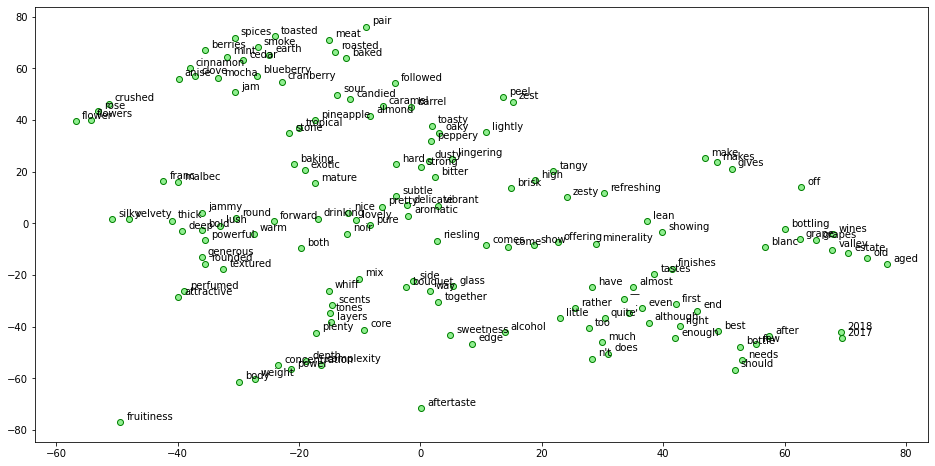

In [ ]:
from sklearn.manifold import TSNE

words = w2vmodel.wv.index2word[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

In [ ]:
# Select topn similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=100)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


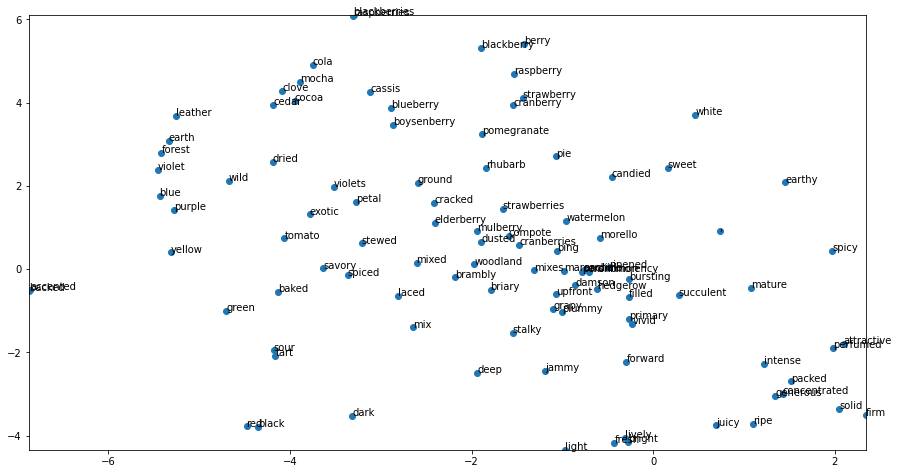

In [ ]:
# Inspect the most similar (play with topn if you like) and change the input token 'red' to other tokens
display_closestwords_tsnescatterplot(w2vmodel, 'red', 100) 

💬  Discuss what you can notice. 
- What type of POS types can you see? Which colours are close to eachother?
- Can you spot higher level concepts, e.g., 'color'?
- Can you find other descriptive words, e.g., words expressing smell/feeling or pattern?

# Weaknesses of Word2Vec

One weakness of the word2vec algorithm is that it has no way of dealing with words that were not in the original training data (OOV). Try, for example, the following:

In [ ]:
try:
  w2vmodel.wv.most_similar('switzerland')
except KeyError as e:
  print(e)

"word 'switzerland' not in vocabulary"


⬆ Try also 'joggers' from the clothing vocabulary

# Pretrained word embeddings
Pretrained word embeddings are vector representation of words trained on a larger dataset. With pretrained embeddings, you will be using the weights and vocabulary from the end result of the training process done by someone else! 

Now check out pretrained word embeddings. This time, not Word2Vec, but GloVe.
The GloVe embeddings used below was trained on an English Wikipedia dump and English Gigaword 5th Edition dataset. Its dimensionality is 100 and has 6B tokens. The original source of the embeddings can be found here: https://nlp.stanford.edu/projects/glove/

In [ ]:
import gensim.downloader as api

# Download the pretrained Glove embeddings. Try fasttext at home.

glove_vectors = api.load("glove-wiki-gigaword-100")                            ## Glove vectors

In [ ]:
glove_vectors.most_similar('wine')

[('wines', 0.8374707698822021),
 ('tasting', 0.7491590976715088),
 ('beer', 0.7244510650634766),
 ('grape', 0.7132691740989685),
 ('champagne', 0.7054867148399353),
 ('coffee', 0.700272798538208),
 ('drink', 0.6808558702468872),
 ('dessert', 0.65183424949646),
 ('drinks', 0.6488078832626343),
 ('taste', 0.6462580561637878)]

In [ ]:
glove_vectors.most_similar('Switzerland')

KeyError: ignored

⬆ Lowercase Switzerland

In [ ]:
## Takes a while to download, try at home
# ft_vectors = api.load('fasttext-wiki-news-subwords-300')                  ## fastText vectors -> will help you with OOV

Conceptually, Word2Vec and fastText have the same goal: to learn vector representations of words. But unlike Word2Vec, which under the hood uses words to predict words, fastText operates at a more granular level with character n-grams. Where words are represented by the sum of the character n-gram vectors.

In [ ]:
# ft_vectors.most_similar('switzerland')

⬆ Capitalize 'switzerland'

💬  Discussion time
What are the closest tokens to 'red', 'silky' and 'wine' in your own embeddings (not in the pretrained)? Write down top three tokens.
What are the advantages and disadvantages of pretrained embeddings?